# Robotic Arm Controlling Reinforcement Learning Agent in 3D-Environment

The following notebook provides a reinforcement learning agent which is trained to control a robotic arm in an episodic Unity 3D-environment. There is a transparent sphere moving around in the environment which marks the goal location. The agent is trained to move the hand of the robotic arm at this location.

### 1. Setup

We begin by importing the Python packages required for the project.

Next, we create the 3D-environment containing the robotic arm. This environment is based on the Unity engine and is provided by Udacity. The environment contains a brain, which is controlled by the reinforcement learning agent used further below.

In [1]:
import keyboard

import matplotlib.pyplot as plt
import numpy as np

from collections import deque
from unityagents import UnityEnvironment

environment = UnityEnvironment("Reacher_Windows_x86_64\Reacher.exe")

brain_name = environment.brain_names[0]
brain = environment.brains[brain_name]

info = environment.reset(train_mode=True)[brain_name]

number_sensors = len(info.vector_observations[0])
number_motors = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Training

Now, we come to the training of the reinforcement learning agent. When the next cell is executed, the Unity environment is shown as a small window and the training starts. The progress of the training is shown in form of a continuously updated log message. The training stops when either an averge score of 30 is reached or the user hits the Escape key. The average score is defined as the non-discounted return, i.e. cumulative reward per episode, computed over the most recent 100 episodes. When the training is finished, a plot of the scores over the episodes is displayed and the neural network of the reinforcement learning agent is saved.

If you have a GPU which requires at least CUDA 9.0, you might encounter a startup-phase taking several minutes for the next cell, because the PyTorch version 0.4.0 required for this project was compiled with CUDA 8.0. Newer versions of PyTorch were not considered here, because this project was created in the context of a Udacity nanodegree program, where the PyTorch version is fixed. So, if the execution freezes, please be patient for a few minutes.

The next cell also contains a fast development mode. When the training has stopped, you can simple execute the cell another time and a new agent is trained with the most recent state of the Python packages coded for the agent, i.e. including any code changes taken since the last execution, without having to restart the Python kernel and the Unity environment. This development mode also addresses the slow startup-phase mentioned above.

CODE DETAILS:

The code in the cell first creates a new agent, which is provided in external Python scripts, and resets the environment. Then, it lets the agent determine an action in the current state. This action causes a change of the environment which is observed and provides a reward. The reward then allows a learning step of the agent. The steps starting with the action determination are then repeated until an episode is finished. Then, the environment is reset and the next episode starts. The training continues over multiple episodes until the stop criterion mentioned earlier is reached.

Fast development reload: network
Fast development reload: memory
Fast development reload: agent
Used device: cpu

Policy Network - Actor(
  (__linear_0): Linear(in_features=33, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=4, bias=True)
)

Target Policy Network - Target Actor(
  (__linear_0): Linear(in_features=33, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=4, bias=True)
)

Q Network - Critic(
  (__linear_0): Linear(in_features=37, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=1, bias=Tru

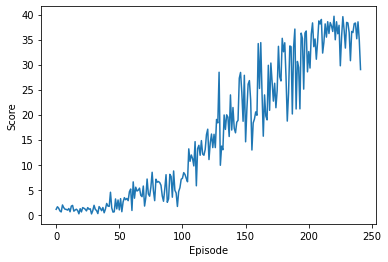

In [3]:
# The nubmer of episodes used to compute the average score.
NUMBER_AVERAGED_EPISODES = 100

# The average score where the training stops.
MAX_AVERAGE_SCORE = 30

import agent

if agent.network.FAST_DEVELOPMENT_MODE:
    import importlib

    importlib.reload(agent)
    print("Fast development reload: agent")

from agent import Agent

agent = Agent(number_sensors, number_motors)

all_scores = []
last_scores = deque(maxlen=NUMBER_AVERAGED_EPISODES)

episode = 0
average_score = 0

reset = True
while True:
    if reset:
        info = environment.reset(train_mode=True)[brain_name]
        state = info.vector_observations[0]
        score = 0
        reset = False

    action = agent(state)
    info = environment.step(action)[brain_name]
    next_state = info.vector_observations[0]
    reward = info.rewards[0]
    done = info.local_done[0]

    epsilon, losses = agent.learn(state, action, reward, next_state, done)

    score += reward
    state = next_state

    if done:
        episode += 1

        all_scores.append(score)
        last_scores.append(score)

        average_score = np.mean(last_scores)

        reset = True

    log = f"\rEpisode = {episode}, Epsilon = {epsilon:.2g}, Losses = ({losses[0]:.2g}, {losses[1]:.2g}), " \
          f"Score = {score:.3g}, Average score = {average_score:.3g}" + 15 * " "
    print(log, end="", flush=True)

    if keyboard.is_pressed("esc") or average_score >= MAX_AVERAGE_SCORE:
        print()
        break

agent.save("agent")

plt.plot(all_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()

### 3. Inference

Execute the next cell to let the saved reinforcement learning to be used in inference mode. This mode also provides a larger window for the Unity environment than in training mode. The inference ends when a single episode is done or the user hits the Escape key.

In [4]:
import agent

if agent.network.FAST_DEVELOPMENT_MODE:
    import importlib

    importlib.reload(agent)
    print("Fast development reload: agent")
    
from agent import Agent

agent = Agent(number_sensors, number_motors)

agent.load("agent")

info = environment.reset(train_mode=False)[brain_name]

score = 0

while True:
    state = info.vector_observations[0]
    action = agent(state)
    info = environment.step(action)[brain_name]
    done = info.local_done[0]
    
    score += info.rewards[0]

    if keyboard.is_pressed("esc") or done:
        break
        
print("Score =", score)

Fast development reload: network
Fast development reload: memory
Fast development reload: agent
Used device: cpu

Policy Network - Actor(
  (__linear_0): Linear(in_features=33, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=4, bias=True)
)

Target Policy Network - Target Actor(
  (__linear_0): Linear(in_features=33, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=4, bias=True)
)

Q Network - Critic(
  (__linear_0): Linear(in_features=37, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=1, bias=Tru

### 4. Teardown

When you are done with training and inference, you can close the Unity environment with the following cell.

In [5]:
environment.close()